---

<center>
<h1>Pronóstico de la productividad forrajera y balance</h1>
<h1>hídrico en la región de los pastizales del Río de la Plata</h1>
</center>

---


<br>
<br>
<ul>
    <li>Bartol, Tomás Augusto</li>
    <li>Peiretti, Pablo </li>
    <li>Sánchez, Milagros Verónica </li>
</li>
</ul>


<br>
<h2>Abstract</h2>

This notebook was created with the purpose of introducing the use of multispectral satellite images as a tool for predicting forage production and water balance in the grasslands of the Río de la Plata. Based on this, the aim is to achieve a more efficient and precise management of resources. Additionally, there will be an attempt to increase livestock productivity by reducing variability in forage production. 

---

# Modules 

This section contains the import statements for external Python modules that are used throughout the notebook. This section is where external libraries or packages are loaded in order to provide additional functionality beyond the basic Python capabilities


In [131]:
### Load the imports ### 
import numpy as np
import pandas as pd
import geopandas as gpd
import tensorflow as tf
from tensorflow.keras import layers, models
from keras.layers import Input, Dense, LSTM
from matplotlib import pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
import matplotlib.dates as mdates
import folium
from branca.colormap import linear
from IPython.display import display
from folium import plugins
from shapely.geometry import Polygon
from shapely.geometry import MultiPoint, MultiPolygon
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
import ipywidgets as widgets
from IPython.display import display


--- 

# Utilities

The Utilities Section in this Jupyter Notebook serves as a collection of tools and auxiliary functions designed to streamline common tasks, enhance code efficiency, and provide reusable functionalities.

In [173]:
""" 
We need a few utilities to simplify object-oriented programming in Jupyter notebooks. One
of the challenges is that class definitions tend to be fairly long blocks of code. Notebook
readability demands short code fragments, interspersed with explanations, a requirement
incompatible with the style of programming common for Python libraries. The first utility
function allows us to register functions as methods in a class after the class has been created.
""" 

class Utils:
    
    
    #Register functions as methods in created class.
    @staticmethod
    def add_method_to_class(Class): #@save

        def wrapper(obj):
            setattr(Class, obj.__name__, obj)
        
        return wrapper
    
    @staticmethod    
    def plot_training_history(fig, history, metric):

        validation_metric = f"val_{metric}"

        fig.plot(history.history[metric], label=f"Training {metric}")
        fig.plot(history.history[validation_metric], label=f"Validation {metric}")
        fig.set_xlabel("Epoch")
        fig.set_ylabel(f"{metric}")
        fig.legend()

        merged_mae_lists = history.history[f"{metric}"][0:] + history.history[f"val_{metric}"][0:]
        highest_loss = max(merged_mae_lists)
        lowest_loss = min(merged_mae_lists)
        delta = highest_loss - lowest_loss
        top_of_y_axis = highest_loss + (delta * 0.05)
        bottom_of_y_axis = lowest_loss - (delta * 0.05)

        fig.set_ylim([bottom_of_y_axis, top_of_y_axis])

    @staticmethod
    def plot_result_in_fixed_position(ax, longitude, latitude, index, model): 
        test_sequence_fixed_position_df = DataManager(test_df[(test_df['longitude'] == longitude) & (test_df['latitude'] == latitude)])
        test_sequence_fixed_position, test_labels_fixed_position = test_sequence_fixed_position_df.sequence_data_preparation(INPUT_STEPS, OUTPUT_STEPS)
        predict = model.predict(test_sequence_fixed_position, verbose=0)
        ax.plot(test_sequence_fixed_position[index,:, -1], label='Input data')
        ax.plot(range(INPUT_STEPS , OUTPUT_STEPS  + INPUT_STEPS), predict[index], label="Model predictions")
        ax.plot(range(INPUT_STEPS , OUTPUT_STEPS  + INPUT_STEPS), test_labels_fixed_position[index], label="Data labels")
        ax.set_xlabel("fortnight")  
        ax.set_ylabel("Normalized PPNA") 
        ax.set_title(f"Prediction for location ['{longitude}','{latitude}']")
        ax.legend()




--- 

# Macros 

The Globals and Macros section in this codebase serves as a centralized hub for managing global variables and macros that impact the entire project. This section is dedicated to storing constants, configuration parameters, and reusable macros that streamline the development process and ensure consistency across various components.

In [133]:
DATABASE_PATH = "Database\database.csv"
SAMPLES_PER_LOCATION = 460
COLORS = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', \
     'lightred', 'darkblue', 'darkgreen', 'cadetblue', \
     'darkpurple', 'pink', 'lightblue', 'lightgreen', 'gray', \
     'black', 'lightgray', 'red', 'blue', 'green', 'purple', \
     'orange', 'darkred', 'lightred', 'beige', 'darkblue', \
     'darkgreen', 'cadetblue', 'darkpurple','pink', 'lightblue', \
     'lightgreen', 'gray', 'black', 'lightgray', 'beige' ]
CLUSTERS_QTY = 8

---

# Data

In this dedicated segment, our primary emphasis will be on the comprehensive visualization and skillful manipulation of the data provided by the MODIS remote sensor. We will delve into the intricacies of presenting the information in a visually impactful manner, ensuring that we not only harness the power of visualization techniques but also adeptly navigate the nuances of manipulating the MODIS dataset for meaningful insights.

In [134]:
"""
Class that manage data and provides methods to visualize it. 
"""

class DataManager(pd.DataFrame):
    
    def load_data(self, filepath):
        try:
            # Load data into the DataFrame itself
            self.__init__(pd.read_csv(filepath))
            self['date'] = pd.to_datetime(self['date'])
            print(f"Data loaded successfully from {filepath}")
        except Exception as e:
            print(f"Error loading data: {e}")

    def date_to_timestamp(self): 
        
        self['timestamp_date'] = pd.to_datetime(self['date'], format='%m/%d/%Y').map(pd.Timestamp.timestamp)

    def show_correlation(self,fig, var1, var2): 

        fig.scatter(self[f"{var1}"], self[f"{var2}"], c='blue', alpha=0.7, s=5)
        r=correlation = self[f"{var1}"].corr(self[f"{var2}"])
        r=round(r,3)
        fig.set_title(f"Correlation between {var1} and {var2} (R = {r})")
        fig.set_xlabel(f'{var1}'.upper())
        fig.set_ylabel(f'{var2}'.upper())
        fig.grid(True)

    def show_ppna_fixed_position (self, fig, latitude, longitude):

        fix_position_df = self[(self['longitude'] == longitude) & (self['latitude'] == latitude)].copy()
        fix_position_df['date'] = pd.to_datetime(fix_position_df['date'])
        fig.plot(fix_position_df['date'], fix_position_df['ppna'], c='blue')
        fig.set_title("PPNA over time in fixed location")
        fig.set_xlabel('Date')
        fig.set_ylabel('PPNA')
        fig.grid(True)

    def show_ppna_year_comparision_fixed_position(self, fig, year1, year2, latitude, longitude): 
        
        fix_position_df = self[(self['longitude'] == longitude) & (self['latitude'] == latitude)].copy()
        fix_position_df['date'] = pd.to_datetime(fix_position_df['date'])

        for year in fix_position_df['date'].dt.year.unique():
            if year == year1 or year == year2:
                year_data = fix_position_df[fix_position_df['date'].dt.year == year]
                dias_meses = [fecha.strftime('%d-%m') for fecha in year_data['date']]
                fig.plot(dias_meses, year_data['ppna'], label=f'Year {year}')

        # Adjusting the x-axis labels for better readability
        fig.tick_params(axis='x', rotation=45)
        fig.set_title("PPNA Comparison over the years")
        fig.set_xlabel('Date')
        fig.set_ylabel('PPNA')
        fig.legend()
        fig.grid(True)

    def show_heat_map(self):

        # Crear un mapa centrado en la ubicación media de tus datos
        mapa = folium.Map(location=[self['latitude'].mean(), self['longitude'].mean()], zoom_start=6)

        # Creo un df con fecha, latitude, longitud y valor de la ppna 
        ppna_heatmaptime_df = self[['date','latitude','longitude','ppna']]
        ppna_heatmaptime_df['date'] = ppna_heatmaptime_df['date'].sort_values(ascending=True)
        data = []
        for _, d in ppna_heatmaptime_df.groupby('date'):
            data.append([[row['latitude'], row['longitude'], row['ppna']] for _, row in d.iterrows()])
        data

        #creo el indice de tiempo para graficar en el mapa 
        time_index = list(ppna_heatmaptime_df['date'].astype('str').unique())


        plugins.HeatMapWithTime(data,
                        index=time_index,
                        auto_play=True,
                        radius=10,
                        use_local_extrema=True
                    ).add_to(mapa)


        # Agrego labels
        """
        Lo dejo comentado por que por performance tarda mucho, despues vemos si lo necesitamos como solucionarlo 
        percentage_to_label = 5  # Porcentaje de puntos para los que se agregarán etiquetas
        total_points = sum(len(points) for points in data)
        points_to_label = [point for points in data for point in points if hash(tuple(point)) % 100 < percentage_to_label]

        for lat, lon, value in points_to_label:
            label = value
            folium.Marker(location=[lat, lon], popup=label).add_to(mapa)

        """

        display(mapa)

    def normalize_data(self):
        mean = self.mean()
        std = self.std()
        self[['ppna', 'ppt', 'temp']] = (self[['ppna', 'ppt', 'temp']] - mean[['ppna', 'ppt', 'temp']]) / std[['ppna', 'ppt', 'temp']]


In [135]:
ppna_df = DataManager()
ppna_df.load_data(DATABASE_PATH) 
ppna_df.info()

Data loaded successfully from Database\database.csv
<class '__main__.DataManager'>
RangeIndex: 690000 entries, 0 to 689999
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         690000 non-null  int64         
 1   date       690000 non-null  datetime64[ns]
 2   longitude  690000 non-null  float64       
 3   latitude   690000 non-null  float64       
 4   ppna       690000 non-null  float64       
 5   ppt        690000 non-null  float64       
 6   temp       690000 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 36.9 MB



## Data Visualization 


In [136]:
ppna_df.head()

,id,date,longitude,latitude,ppna,ppt,temp
0,0,2001-01-01,-56.83242,-31.544792,405.340618,76.155505,24.333897
1,1,2001-01-17,-56.83242,-31.544792,362.433361,91.647396,23.921929
2,2,2001-02-02,-56.83242,-31.544792,420.441046,80.999538,24.132180
3,3,2001-02-18,-56.83242,-31.544792,335.261458,88.673292,26.170466
4,4,2001-03-06,-56.83242,-31.544792,301.399079,5.496469,24.043910


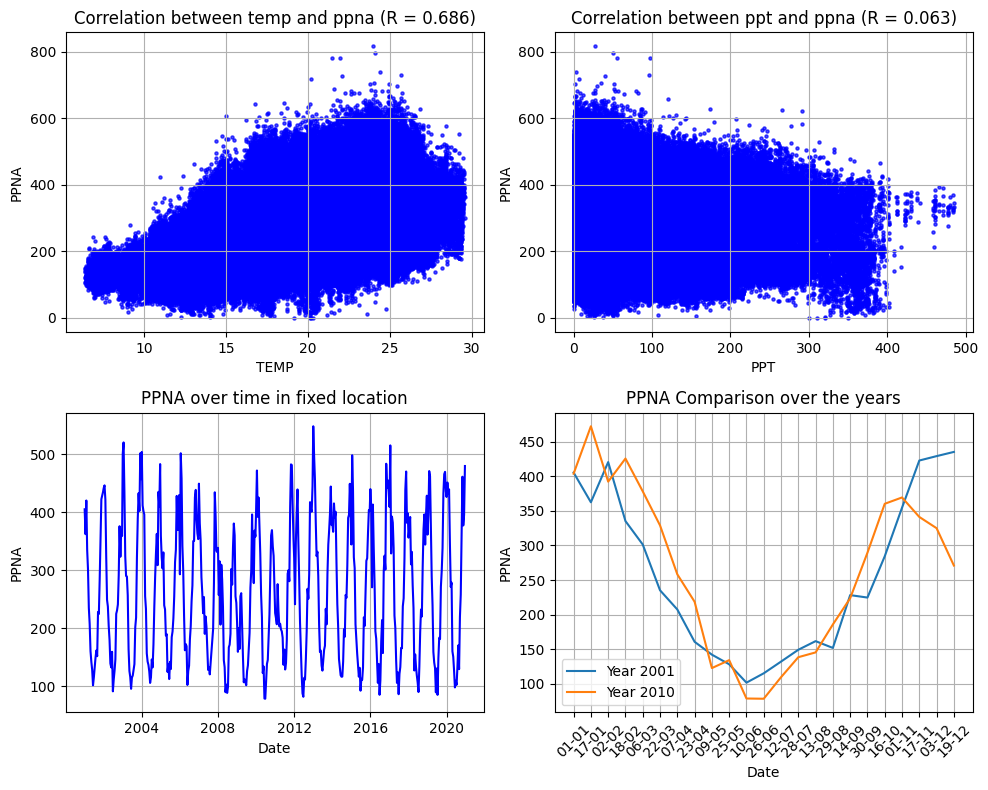

In [137]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
pd.options.mode.chained_assignment = None

ppna_df.show_correlation(axes[0,0], 'temp', 'ppna')
ppna_df.show_correlation(axes[0,1], 'ppt', 'ppna')
ppna_df.show_ppna_fixed_position(axes[1,0], ppna_df['latitude'][100], ppna_df['longitude'][100])
ppna_df.show_ppna_year_comparision_fixed_position(axes[1,1], 2001, 2010, ppna_df['latitude'][0], ppna_df['longitude'][0])

fig.tight_layout()
plt.show()

## Data Managment

In [138]:
"""
Convert from date to timestamp format
""" 
ppna_df.date_to_timestamp()

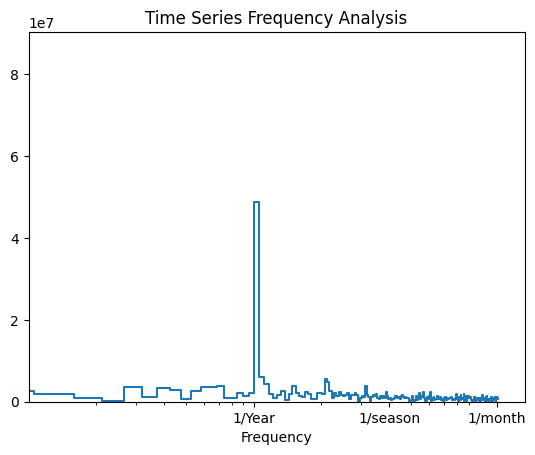

In [139]:
"""
Temporal periodicity analysis of our data set, where it can be seen that it has a very important annual periodicity.
"""

# group dataframe by date 
combined_series = ppna_df.groupby(['date'])['ppna'].sum().sort_index()


# Apply FFT
fft = tf.signal.rfft(combined_series)
f_per_dataset = np.arange(0, len(fft))


n_samples_h = len(combined_series)
f_sample = 15 #1 sample every 15 days 
years_per_dataset = n_samples_h * f_sample / 365  #number of samples * frecuency sample day * num of days in a year give me the number of years 
f_per_year = f_per_dataset / years_per_dataset

# Grafica la amplitud de las frecuencias en una escala de logaritmo.
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, max( np.abs(fft) /2))
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 4, 12], labels=['1/Year', '1/season', '1/month'])
plt.title('Time Series Frequency Analysis' )
plt.xlabel('Frequency')
plt.show()

Text(0.5, 1.0, 'Time signal')

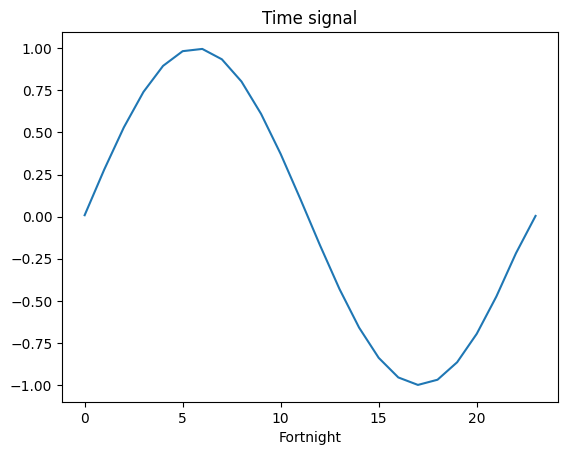

In [140]:
"""
Time in seconds is not a useful input for the model. Being meteorological data, it exhibits clear daily and annual periodicity. There are many ways to deal with this periodicity.
You can obtain usable signals by using sine and cosine transformations to remove the "Time of day" and "Time of year" signals.
As we previously analyzed, the most important time dependence is annual, therefore, we will use a time signal with an annual period.
"""
day = 24*60*60
year = (365.2425)*day


ppna_df['date_signal'] = np.sin(ppna_df['timestamp_date'] * (2 * np.pi / year))

plt.plot(np.array(ppna_df['date_signal'])[:24]) #veinticinco muestras son casi un año (15 * 24 = 360 dias) y vemos ue se cumple un periodo de la señal temporal
plt.xlabel('Fortnight')
plt.title('Time signal')



In [141]:
"""
Divide the dataframe into three sections (train, test, validation) with roughly a 70-20-10 distribution. 
As we have 20 years of data, it is going to be diveded into 14 years, 4 years and 2 years (70%,20% and 10%).
The samples are divided secuentially to improve the RNN performance.
"""

#ppna_df =  ppna_df[(ppna_df['longitude'] == ppna_df['longitude'][100]) & (ppna_df['latitude'] == ppna_df['latitude'][100])].copy() #-> lo hago para una sola ubicacion, despues hay que ver como cambiar esto 
train_df = DataManager(ppna_df[ppna_df['date'] < '2014-01-01'][[ 'date_signal', 'latitude', 'longitude', 'ppt','temp', 'ppna']])
val_df =  DataManager(ppna_df[(ppna_df['date'] >= '2014-01-01') & (ppna_df['date'] < '2019-01-01')][[ 'date_signal', 'latitude', 'longitude', 'ppt', 'temp', 'ppna']])
test_df = DataManager(ppna_df[ppna_df['date'] >= '2019-01-01'][['date_signal', 'latitude', 'longitude', 'ppt','temp', 'ppna']])

In [142]:
"""
Normalization of every dataframe. The chosen normalization uses mean and standard deviation
Every Dataframe must be normalized by the same values, hence the train df mean and deviation are saved

(También es discutible que el modelo no debería tener acceso a valores futuros en el conjunto de entrenamiento 
durante el entrenamiento, y que esta normalización debería hacerse usando promedios móviles. Ese no es el enfoque 
de este tutorial, y los conjuntos de validación y prueba aseguran que obtenga métricas (algo) honestas. 
Entonces, en aras de la simplicidad, este tutorial usa un promedio simple.) 

https://medium.com/@spinjosovsky/normalize-data-before-or-after-split-of-training-and-testing-data-7b8005f81e26
https://datascience.stackexchange.com/questions/27615/should-we-apply-normalization-to-test-data-as-well
"""
train_df.normalize_data()
val_df.normalize_data()
test_df.normalize_data()

### Data Window

We first need to prepare the data to be fed into an LSTM. The LSTM model learns a function that maps a sequence of past observations as input to an output observation. As such, the sequence of observations must be transformed into multiple examples from which the LSTM can learn.

To make it concrete in terms of the speed prediction problem, we choose to use 1 year of historical observations to predict the future, lets say, 15 days ahead. Hence, we would first reshape the timeseries data into windows of 24 historical observations for each segment as the input and the speed 15 days later is the label we are interested in predicting. We use the sliding window approach to prepare the data. This is how it works:

Starting from the beginning of the timeseries, we take the first 24 records as the 24 input features and the speed 1 timesteps head (15 days) as the ppna we want to predict.

Shift the timeseries by one timestep and take the 24 observations from the current point as the input features and the speed 15 days ahead as the output to predict.

Keep shifting by 1 timestep and picking the 24 timestep window from the current time as input feature and the speed one hour ahead of the 10th timestep as the output to predict, for the entire data.

The above steps are done for latitude and longitude. 

The function below returns the above transformed timeseries data for the model to train on. The parameter seq_len is the size of the past window of information. The pre_len is how far in the future does the model need to learn to predict.

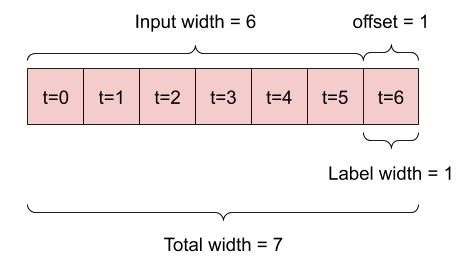

In [143]:
"""
This function is main in a LSTM model, prepare the data in form of past observations and future lable. For example, if the data is [1,2,3,4,5,6,7,8,9,10], the seq_len = 5 and the pre_len = 1: 
past_data = [[1],[2],[3],[4],[5]] , label data = [6]
past_data = [[2],[3],[4],[5],[6]] , label data = [7]
and so on...
"""

# Apply decorator to add the sequence data preparation to DataManager class 
@Utils.add_method_to_class(DataManager)
def sequence_data_preparation(self, seq_len, pre_len):

    past_data = []  # Window for the past 
    label_data = []  # Predict next value 

    for i in range(self.shape[0] - int(seq_len + pre_len - 1)):
        a = self[i: i + seq_len + pre_len] 
        past_data.append(a[:seq_len])
        label_data.append(a[-pre_len:]['ppna'])

    past_data = np.array(past_data)
    label_data = np.array(label_data)

    return past_data, label_data


--- 

# Recurrent Neuronal Network

In this section, we delve into the examination and analysis of various topologies within recurrent neural networks (RNNs) with the primary goal of estimating and predicting the productivity of forage production. Forage production, a critical aspect of agricultural ecosystems, can be influenced by a multitude of factors, and leveraging the capabilities of RNNs allows us to capture the temporal dependencies inherent in such dynamic systems.

## LSTM - Multivariable 

We will embark on the construction of a Long Short-Term Memory (LSTM) neural network tailored for the PPNA. Leveraging the power of LSTM architecture, we aim to develop a robust model capable of capturing temporal dependencies within the data, ultimately enhancing our ability to forecast PPNA trends. Throughout this endeavor, we will explore the intricacies of LSTM networks, fine-tune model parameters, and implement effective training strategies to optimize predictive accuracy.

A recurrent model can learn to use a long history of inputs if it is relevant for the predictions the model makes. 
Here, the model will accumulate internal state over a year (24 samples) before making a single prediction for the next 15 days (1 sample).

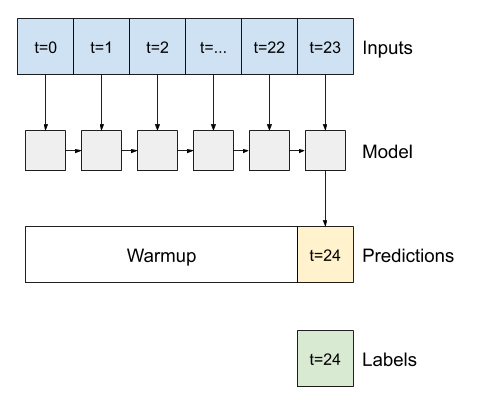

In [144]:
INPUT_STEPS = 24 #1 Year
OUTPUT_STEPS = 12 #15 DAYS
train_sequence, train_labels = train_df.sequence_data_preparation(INPUT_STEPS, OUTPUT_STEPS)
val_sequence, val_labels = val_df.sequence_data_preparation(INPUT_STEPS, OUTPUT_STEPS)
test_sequence, test_labels = test_df.sequence_data_preparation(INPUT_STEPS, OUTPUT_STEPS)
print("train sequence: (num train data, past_data, features) ->", test_sequence.shape)
print("label sequence: (num train data, output_steps) -> ", test_labels.shape)

train sequence: (num train data, past_data, features) -> (68965, 24, 6)
label sequence: (num train data, output_steps) ->  (68965, 12)


In [145]:
"""
Neuronal Network Model for LSTM one shot 
"""

LEARNING_RATE = 0.000003

model_one_shot = tf.keras.Sequential()

model_one_shot.add(Input((INPUT_STEPS, train_df.shape[1])))

model_one_shot.add(LSTM(128))

model_one_shot.add(Dense(32,'relu'))

model_one_shot.add(Dense(OUTPUT_STEPS * 1,'linear'))

model_one_shot.summary()

model_one_shot.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(learning_rate=LEARNING_RATE),
                metrics=[tf.metrics.RootMeanSquaredError()])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='root_mean_squared_error',
                                                patience=2,
                                                mode='min')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128)               69120     
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dense_3 (Dense)             (None, 12)                396       
                                                                 
Total params: 73644 (287.67 KB)
Trainable params: 73644 (287.67 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [146]:
"""
The .fit method is a crucial step in the machine learning workflow, where a model learns patterns and relationships 
from a training dataset. During the training process, the model adjusts its internal parameters based on the input 
data and corresponding target values. The goal is to minimize the difference between the model's predictions and the
 actual target values. The training process involves iteratively updating the model parameters through techniques like 
 gradient descent or other optimization algorithms.
"""

EPOCHS = 5
history = model_one_shot.fit(train_sequence, train_labels, validation_data=(val_sequence,val_labels), epochs=EPOCHS, batch_size=32, callbacks=[early_stopping])

Epoch 1/5
14015/14015 [==============================] - 236s 17ms/step - loss: 0.8252 - root_mean_squared_error: 0.9084 - val_loss: 0.4660 - val_root_mean_squared_error: 0.6826
Epoch 2/5
14015/14015 [==============================] - 237s 17ms/step - loss: 0.3528 - root_mean_squared_error: 0.5939 - val_loss: 0.2364 - val_root_mean_squared_error: 0.4862
Epoch 3/5
14015/14015 [==============================] - 348s 25ms/step - loss: 0.2668 - root_mean_squared_error: 0.5165 - val_loss: 0.2275 - val_root_mean_squared_error: 0.4770
Epoch 4/5
14015/14015 [==============================] - 352s 25ms/step - loss: 0.2530 - root_mean_squared_error: 0.5030 - val_loss: 0.2298 - val_root_mean_squared_error: 0.4794
Epoch 5/5
14015/14015 [==============================] - 318s 23ms/step - loss: 0.2443 - root_mean_squared_error: 0.4943 - val_loss: 0.2342 - val_root_mean_squared_error: 0.4839


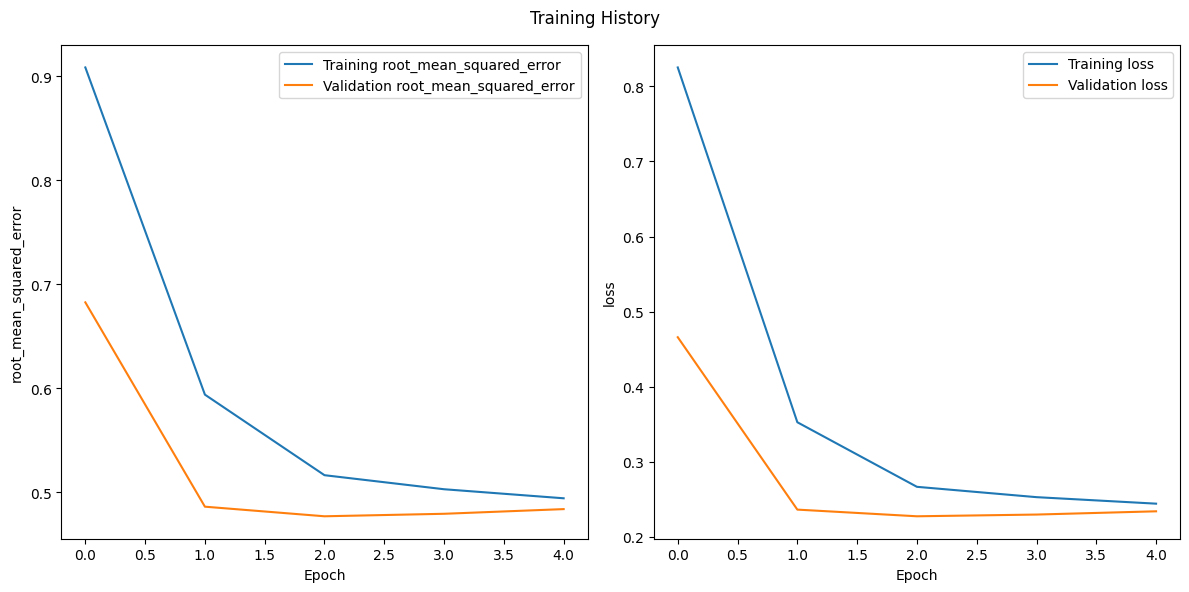

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
pd.options.mode.chained_assignment = None


# plot training history
Utils.plot_training_history(axes[0], history, "root_mean_squared_error")
Utils.plot_training_history(axes[1], history, "loss")

# Mostrar el gráfico
fig.suptitle("Training History")
fig.tight_layout()
plt.show()


In [148]:
"""
Evaluate the model over the validation data, if the metrics are not good, change the model an test again
"""
metric = model_one_shot.evaluate(val_sequence, val_labels)

print("The values of Loss and Root Mean Squared Error are: ", metric)

5390/5390 [==============================] - 34s 6ms/step - loss: 0.2342 - root_mean_squared_error: 0.4839
The values of Loss and Root Mean Squared Error are:  [0.23416852951049805, 0.48390987515449524]


In [176]:
index_slider = widgets.IntSlider(min=0, max=OUTPUT_STEPS-2 , step=1, value=0, description='Fortnight:', layout=widgets.Layout(width='60%', margin='0px 0px 0px 0px'))

def update_plot(index):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    fig.suptitle('Model Resuts')
    plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.4, hspace=0.4)
    Utils.plot_result_in_fixed_position(axes[0,0],ppna_df['longitude'][400000], ppna_df['latitude'][400000],index, model_one_shot)
    Utils.plot_result_in_fixed_position(axes[0,1],ppna_df['longitude'][0], ppna_df['latitude'][0],index, model_one_shot)
    Utils.plot_result_in_fixed_position(axes[1,0],ppna_df['longitude'][10000], ppna_df['latitude'][10000],index, model_one_shot)
    Utils.plot_result_in_fixed_position(axes[1,1],ppna_df['longitude'][30000], ppna_df['latitude'][30000],index,  model_one_shot)
    


widgets.interactive(update_plot, index=index_slider)


interactive(children=(IntSlider(value=0, description='Fortnight:', layout=Layout(margin='0px 0px 0px 0px', wid…

## CONV LSTM - Multivariable 

In [196]:
#[samples, timesteps, rows, cols, channels]
#train_x = train_x.reshape((train_x.shape[0], n_steps, 1, n_length, n_features))
train_x =  train_sequence.reshape((train_sequence.shape[0], 2, 1, 12, 6))
val_x = val_sequence.reshape((val_sequence.shape[0],2,1,12,6))
test_x =  test_sequence.reshape((test_sequence.shape[0], 2, 1, 12, 6))
print("(samples, timesteps, rows, cols, channels) ->", train_x.shape)

(samples, timesteps, rows, cols, channels) -> (448465, 2, 1, 12, 6)


In [198]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, Flatten, RepeatVector, LSTM, TimeDistributed, Dense

model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(2, 1, 12, 6)))
model.add(Flatten())
model.add(RepeatVector(12))
model.add(LSTM(200, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(100, activation='relu')))
model.add(TimeDistributed(Dense(1)))
model.compile(loss='mse', optimizer='adam')

In [199]:
model.fit(train_x, train_labels,validation_data=(val_x,val_labels), epochs=3, batch_size=32, verbose=1)

Epoch 1/3
14015/14015 [==============================] - 515s 37ms/step - loss: 0.1485 - val_loss: 0.2726
Epoch 2/3
14015/14015 [==============================] - 570s 41ms/step - loss: 0.0864 - val_loss: 0.2951
Epoch 3/3
14015/14015 [==============================] - 12426s 887ms/step - loss: 0.0778 - val_loss: 0.2970


In [177]:
result_x = model.predict(test_x)

2156/2156 [==============================] - 16s 8ms/step


1/1 [==============================] - 0s 32ms/step


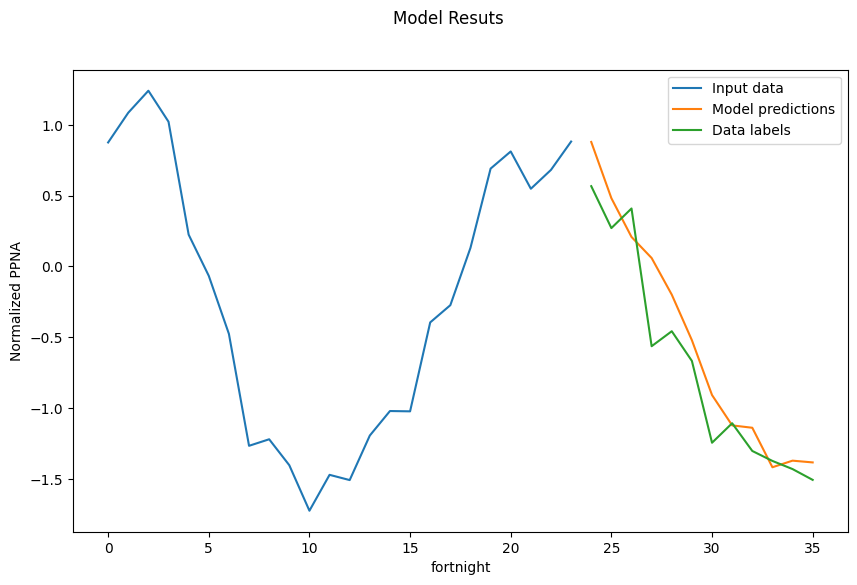

In [192]:
test_sequence_fixed_position_df = DataManager(test_df[(test_df['longitude'] == ppna_df['longitude'][11100]) & (test_df['latitude'] == ppna_df['latitude'][11100])])
test_sequence_fixed_position, test_labels_fixed_position = test_sequence_fixed_position_df.sequence_data_preparation(INPUT_STEPS, OUTPUT_STEPS)
test_x = test_sequence_fixed_position.reshape((test_sequence_fixed_position.shape[0], 2, 1, 12, 6))
predict = model.predict(test_x)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
fig.suptitle('Model Resuts')

ax.plot(test_sequence_fixed_position[0,:, -1], label='Input data')
ax.plot(range(INPUT_STEPS , OUTPUT_STEPS  + INPUT_STEPS), predict[0], label="Model predictions")
ax.plot(range(INPUT_STEPS , OUTPUT_STEPS  + INPUT_STEPS), test_labels_fixed_position[0], label="Data labels")
ax.set_xlabel("fortnight")  
ax.set_ylabel("Normalized PPNA") 
ax.legend()



### Tests for efficient data clustering

https://towardsdatascience.com/cheat-sheet-to-implementing-7-methods-for-selecting-optimal-number-of-clusters-in-python-898241e1d6ad
https://www.analyticsvidhya.com/blog/2021/01/in-depth-intuition-of-k-means-clustering-algorithm-in-machine-learning/

###### NOTA: debatir si sacar PPNA como metodo de clustering porque despues no se va a poder usar

In [150]:
ppna_df_feature_cross = DataManager()
ppna_df_feature_cross.load_data(DATABASE_PATH) 
ppna_df_feature_cross.info()

Data loaded successfully from Database\database.csv
<class '__main__.DataManager'>
RangeIndex: 690000 entries, 0 to 689999
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         690000 non-null  int64         
 1   date       690000 non-null  datetime64[ns]
 2   longitude  690000 non-null  float64       
 3   latitude   690000 non-null  float64       
 4   ppna       690000 non-null  float64       
 5   ppt        690000 non-null  float64       
 6   temp       690000 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 36.9 MB


In [151]:
'''
Elbow method to determine the most efficient number of centroids. The optimal value will be that 
in which the function plot "bends" and "forms an elbow"
'''

def elbow_method(data, max_clusters=10):
    X = data[['latitude', 'longitude']]

    distortions = []
    for i in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
        kmeans.fit(X)
        distortions.append(kmeans.inertia_)


    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_clusters + 1), distortions, marker='o')
    plt.title('Elbow Method for Optimal k')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Distortion')
    plt.show()


elbow_method(ppna_df_feature_cross, 15)


KeyboardInterrupt: 

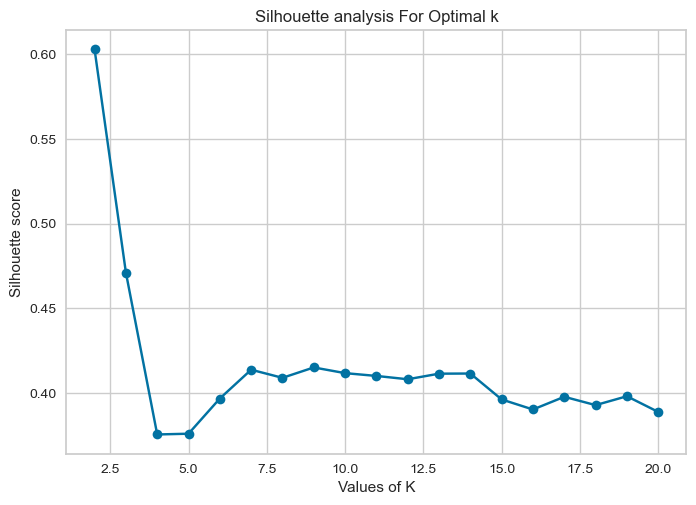

In [ ]:
'''
Average Silhouette method to determine the most efficient number of centroids. The optimal value will be that for which the 
silhouette score is closer to 1, indicating that every datapoint is near the centroid and the clusters are more compact.
The method is not 100% efficient as the dataset must be shortened to one sample per location because of computing limitations
'''


def silhouette_method(dataset, max_clusters):
 
    k_values = range(2, max_clusters + 1)
    silhouette_scores = []

    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init = 10)
        cluster_labels = kmeans.fit_predict(X)
        silhouette_avg = silhouette_score(X, cluster_labels)
        silhouette_scores.append(silhouette_avg)

    plt.plot(k_values, silhouette_scores, marker='o')
    plt.xlabel('Values of K') 
    plt.ylabel('Silhouette score') 
    plt.title('Silhouette analysis For Optimal k')
    plt.show()

   
    optimal_k = k_values[np.argmax(silhouette_scores)]
    return optimal_k

counter = 0
X = []
for _, row in ppna_df_feature_cross.iterrows():

    if counter % SAMPLES_PER_LOCATION == 0:
        X.append([row["latitude"], row["longitude"]])
    
    counter += 1
    
optimal_k = silhouette_method(X, 20)


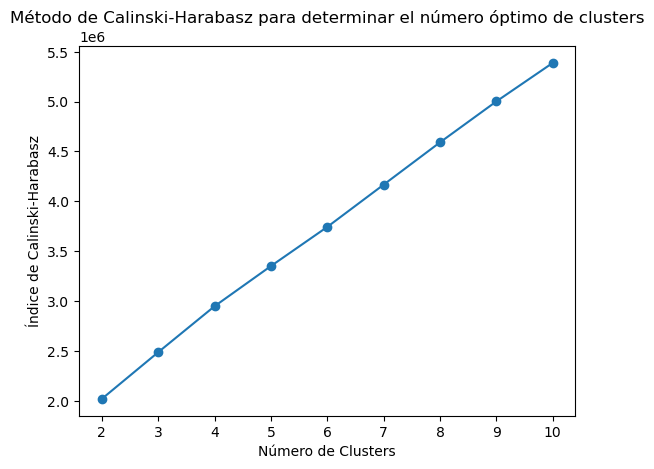

In [ ]:
'''
Calinski-Harabasz method to determine the most efficient number of centroids. The optimal value will be that for which the 
index is higher, indicating that the clusters are more separated and defined.

https://www.geeksforgeeks.org/calinski-harabasz-index-cluster-validity-indices-set-3/
'''

def calinski_harabasz_method(X, max_clusters):
    scores = []
    
    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X)
        score = calinski_harabasz_score(X, kmeans.labels_)
        scores.append(score)
    
    plt.plot(range(2, max_clusters + 1), scores, marker='o')
    plt.xlabel('Número de Clusters')
    plt.ylabel('Índice de Calinski-Harabasz')
    plt.title('Método de Calinski-Harabasz para determinar el número óptimo de clusters')
    plt.show()


X = ppna_df_feature_cross[['latitude', 'longitude', 'ppna']]
calinski_harabasz_method(X, 10)




c:\Users\CARLOS\anaconda3\Lib\site-packages\yellowbrick\utils\kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
c:\Users\CARLOS\anaconda3\Lib\site-packages\yellowbrick\cluster\elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


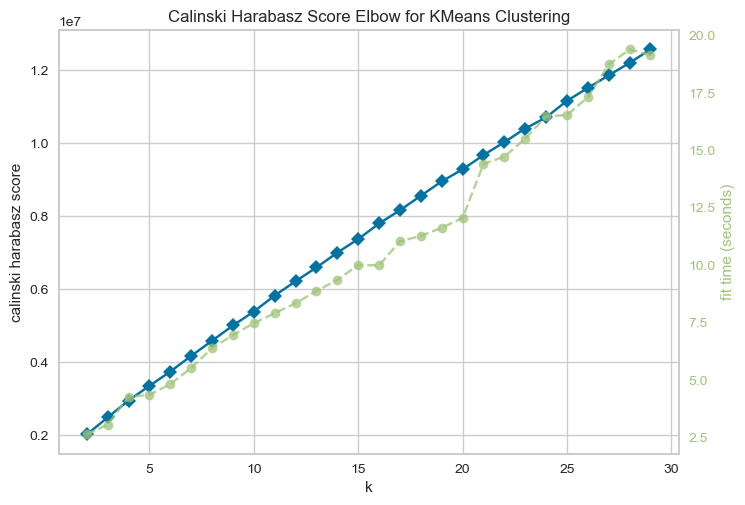

<Axes: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [ ]:
#Otro metodo de calinski-Harabasz para chequear

from yellowbrick.cluster import KElbowVisualizer
model = KMeans(n_init=10)
X = ppna_df_feature_cross[['latitude', 'longitude', 'ppna']]
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30),metric='calinski_harabasz', timings= True)
visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()

### Data Clustering

This section shows the algorhitms used to categorize each value into a cluster. It also provides several maps to show the geographical caracteristics of the dataset

https://journals.openedition.org/cybergeo/27035 (Para justificar uso de K-means de geometria euclidea)
https://www.analyticsvidhya.com/blog/2019/08/comprehensive-guide-k-means-clustering/ (Buena info de como funciona el clustering)

In [ ]:

X = ppna_df_feature_cross[['latitude', 'longitude']]
kmeans = KMeans(
    init="random",
    n_clusters=CLUSTERS_QTY,
    n_init=10,
    max_iter=300,
    random_state=42
).fit(X)

labels = kmeans.labels_
X['cluster'] = labels



In [ ]:
X.info()
kmeans.labels_

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690000 entries, 0 to 689999
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   latitude   690000 non-null  float64
 1   longitude  690000 non-null  float64
 2   cluster    690000 non-null  int32  
dtypes: float64(2), int32(1)
memory usage: 13.2 MB


array([2, 2, 2, ..., 2, 2, 2])

In [ ]:
centers = kmeans.cluster_centers_
print(centers)

[[-32.96561138 -56.16084226]
 [-30.74992528 -57.4256069 ]
 [-31.38522276 -57.33303046]
 [-32.94988952 -56.81693907]
 [-30.4463202  -56.89231138]
 [-31.01473872 -56.56030095]
 [-32.28556286 -56.19177935]
 [-32.22637987 -56.81737086]]


In [ ]:
clusters = X.groupby('cluster').count()
print(clusters)

         latitude  longitude
cluster                     
0           70380      70380
1          109020     109020
2          106260     106260
3           60720      60720
4           84640      84640
5           83260      83260
6          104880     104880
7           70840      70840


In [ ]:
ppna_df_feature_cross['date'][SAMPLES_PER_LOCATION]


Timestamp('2001-01-01 00:00:00')

In [ ]:
'''
Plot every location on the map, color coded by the cluster they belong to
'''


map = folium.Map(location=[ppna_df_feature_cross['latitude'].mean(), ppna_df_feature_cross['longitude'].mean()], zoom_start=6)
counter = 0
for _, row in X.iterrows():

    if counter % SAMPLES_PER_LOCATION == 0:
        folium.CircleMarker(
            location=[row["latitude"], row["longitude"]],
            radius=8, 
            weight=2, 
            fill=True, 
            fill_color=COLORS[int(row["cluster"])],
            color=COLORS[int(row["cluster"])]
        ).add_to(map)
    

    counter += 1
map



In [ ]:
for centroide in centers:
    #latitud, longitud = centroide  # Desempaqueta las coordenadas del centroide
    print(f"Latitud: {centroide[0]}, Longitud: {centroide[1]}")

Latitud: -32.965611379999984, Longitud: -56.1608422599347
Latitud: -30.74992527772154, Longitud: -57.42560690016871
Latitud: -31.385222760043288, Longitud: -57.33303045757577
Latitud: -32.94988951719705, Longitud: -56.81693906689394
Latitud: -30.446320196195682, Longitud: -56.8923113773913
Latitud: -31.01473871662986, Longitud: -56.56030095430939
Latitud: -32.28556286223684, Longitud: -56.191779348903474
Latitud: -32.22637986688315, Longitud: -56.81737085694805


In [ ]:
'''
Plot every centroid on the map, color coded by the cluster they belong to
'''

map = folium.Map(location=[ppna_df_feature_cross['latitude'].mean(), ppna_df_feature_cross['longitude'].mean()], zoom_start=6)

counter = 0
for centroid in centers:

    folium.CircleMarker(
        location=[centroid[0], centroid[1]],
        radius=4, 
        weight=2, 
        fill=True, 
        fill_color=COLORS[counter],
        color=COLORS[counter]
        ).add_to(map)

    counter += 1

map

In [ ]:
'''
Prints map with cluster contours obtained from the dataset locations. It uses a convex_hull (hull= shell, contour)
which sets the simplest contour to be drawn around a given set of points (like a rubber band on tacks)
'''


#Create a dictionary with points grouped by clusters. The cluster id is the dictionary key and the coordinates are the dictionary data
clustered_points = {}
for _, row in X.iterrows():
    cluster_id = int(row["cluster"])
    if cluster_id not in clustered_points:
        clustered_points[cluster_id] = []
    clustered_points[cluster_id].append((row["latitude"], row["longitude"]))

# Create a polygon dictionary. Key=cluster id; data=convex hull.
cluster_polygons = {}
for cluster_id, points in clustered_points.items():
    multipoint = MultiPoint(points)
    convex_hull = multipoint.convex_hull
    cluster_polygons[cluster_id] = convex_hull

map = folium.Map(location=[ppna_df_feature_cross['latitude'].mean(), ppna_df_feature_cross['longitude'].mean()], zoom_start=6)

for cluster_id, polygon in cluster_polygons.items():
    coords = list(polygon.exterior.coords)
    folium.Polygon(locations=coords, color=COLORS[cluster_id], fill=True, fill_color=COLORS[cluster_id], fill_opacity=0.3).add_to(map)


map

In [ ]:
'''
Prints map with the whole area to be analized by data. Mainly for showing purposes
'''


map = folium.Map(location=[ppna_df_feature_cross['latitude'].mean(), ppna_df_feature_cross['longitude'].mean()], zoom_start=6)


multipoint = MultiPoint(ppna_df_feature_cross[['latitude', 'longitude']].values)
convex_hull = multipoint.convex_hull


coords = list(convex_hull.exterior.coords)
folium.Polygon(locations=coords, color='blue', fill=True, fill_color='blue', fill_opacity=0.3).add_to(map)


map

In [ ]:
# Make X_train_clustering which uses a one-hot encoding from the cluster label

X_train_clustering = pd.get_dummies(pd.Series(kmeans.labels_)).to_numpy()
X_train_clustering

array([[False, False,  True, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       ...,
       [False, False,  True, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       [False, False,  True, ..., False, False, False]])

In [ ]:
ppna_df_feature_cross.info()

<class '__main__.DataManager'>
RangeIndex: 690000 entries, 0 to 689999
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   id              690000 non-null  int64         
 1   date            690000 non-null  datetime64[ns]
 2   longitude       690000 non-null  float64       
 3   latitude        690000 non-null  float64       
 4   ppna            690000 non-null  float64       
 5   ppt             690000 non-null  float64       
 6   temp            690000 non-null  float64       
 7   timestamp_date  690000 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 42.1 MB


In [ ]:
ppna_df_feature_cross.head()

,id,date,longitude,latitude,ppna,ppt,temp,timestamp_date
0,0,2001-01-01,-56.83242,-31.544792,405.340618,76.155505,24.333897,978307200.0
1,1,2001-01-17,-56.83242,-31.544792,362.433361,91.647396,23.921929,979689600.0
2,2,2001-02-02,-56.83242,-31.544792,420.441046,80.999538,24.132180,981072000.0
3,3,2001-02-18,-56.83242,-31.544792,335.261458,88.673292,26.170466,982454400.0
4,4,2001-03-06,-56.83242,-31.544792,301.399079,5.496469,24.043910,983836800.0


In [ ]:
#Create df with one hot encoding
one_hot_df = pd.get_dummies(pd.Series(kmeans.labels_), prefix='cluster')

#Turn 1s and 0s into int
one_hot_df = one_hot_df.astype(bool).astype(int)

#Add one hot encoded clusters to original df
ppna_df_feature_cross = pd.concat([ppna_df_feature_cross, one_hot_df], axis=1)


In [ ]:

ppna_df_feature_cross.head(598)



,id,date,longitude,latitude,ppna,ppt,temp,timestamp_date,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7
0,0,2001-01-01,-56.83242,-31.544792,405.340618,76.155505,24.333897,9.783072e+08,0,0,1,0,0,0,0,0
1,1,2001-01-17,-56.83242,-31.544792,362.433361,91.647396,23.921929,9.796896e+08,0,0,1,0,0,0,0,0
2,2,2001-02-02,-56.83242,-31.544792,420.441046,80.999538,24.132180,9.810720e+08,0,0,1,0,0,0,0,0
3,3,2001-02-18,-56.83242,-31.544792,335.261458,88.673292,26.170466,9.824544e+08,0,0,1,0,0,0,0,0
4,4,2001-03-06,-56.83242,-31.544792,301.399079,5.496469,24.043910,9.838368e+08,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,593,2006-10-16,-56.63036,-30.548958,441.944583,62.206829,20.132488,1.160957e+09,0,0,0,0,1,0,0,0
594,594,2006-11-01,-56.63036,-30.548958,422.993799,92.307355,20.042935,1.162339e+09,0,0,0,0,1,0,0,0
595,595,2006-11-17,-56.63036,-30.548958,395.185701,71.117588,21.230592,1.163722e+09,0,0,0,0,1,0,0,0
596,596,2006-12-03,-56.63036,-30.548958,320.306406,123.580209,25.206299,1.165104e+09,0,0,0,0,1,0,0,0


In [ ]:
ppna_df_feature_cross.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690000 entries, 0 to 689999
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   id              690000 non-null  int64         
 1   date            690000 non-null  datetime64[ns]
 2   longitude       690000 non-null  float64       
 3   latitude        690000 non-null  float64       
 4   ppna            690000 non-null  float64       
 5   ppt             690000 non-null  float64       
 6   temp            690000 non-null  float64       
 7   timestamp_date  690000 non-null  float64       
 8   cluster_0       690000 non-null  int32         
 9   cluster_1       690000 non-null  int32         
 10  cluster_2       690000 non-null  int32         
 11  cluster_3       690000 non-null  int32         
 12  cluster_4       690000 non-null  int32         
 13  cluster_5       690000 non-null  int32         
 14  cluster_6       690000 non-null  int

### Train model with the clustered dataset

In [ ]:
ppna_df_feature_cross['timestamp_date'] = pd.to_datetime(ppna_df_feature_cross['date'], format='%m/%d/%Y').map(pd.Timestamp.timestamp)
ppna_df_feature_cross.head()

,id,date,longitude,latitude,ppna,ppt,temp,timestamp_date
0,0,2001-01-01,-56.83242,-31.544792,405.340618,76.155505,24.333897,978307200.0
1,1,2001-01-17,-56.83242,-31.544792,362.433361,91.647396,23.921929,979689600.0
2,2,2001-02-02,-56.83242,-31.544792,420.441046,80.999538,24.132180,981072000.0
3,3,2001-02-18,-56.83242,-31.544792,335.261458,88.673292,26.170466,982454400.0
4,4,2001-03-06,-56.83242,-31.544792,301.399079,5.496469,24.043910,983836800.0


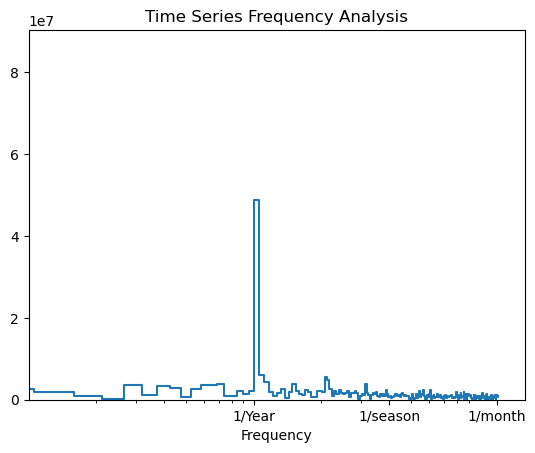

In [ ]:
"""
Temporal periodicity analysis of our data set, where it can be seen that it has a very important annual periodicity.
"""

# group dataframe by date 
combined_series = ppna_df_feature_cross.groupby(['date'])['ppna'].sum().sort_index()


# Apply FFT
fft = tf.signal.rfft(combined_series)
f_per_dataset = np.arange(0, len(fft))


n_samples_h = len(combined_series)
f_sample = 15 #1 sample every 15 days 
years_per_dataset = n_samples_h * f_sample / 365  #number of samples * frecuency sample day * num of days in a year give me the number of years 
f_per_year = f_per_dataset / years_per_dataset

# Grafica la amplitud de las frecuencias en una escala de logaritmo.
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, max( np.abs(fft) /2))
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 4, 12], labels=['1/Year', '1/season', '1/month'])
plt.title('Time Series Frequency Analysis' )
plt.xlabel('Frequency')
plt.show()

Text(0.5, 1.0, 'Time signal')

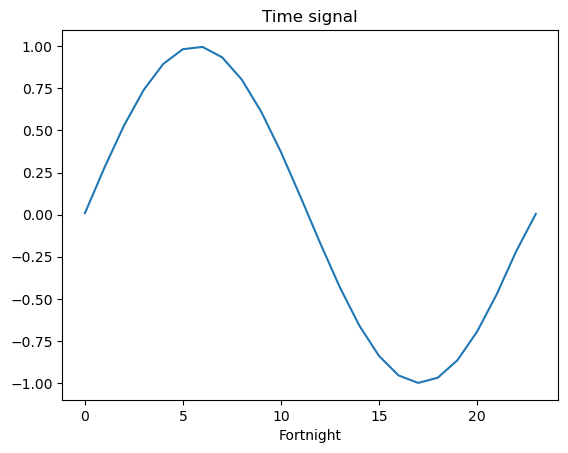

In [ ]:
"""
Time in seconds is not a useful input for the model. Being meteorological data, it exhibits clear daily and annual periodicity. There are many ways to deal with this periodicity.
You can obtain usable signals by using sine and cosine transformations to remove the "Time of day" and "Time of year" signals.
As we previously analyzed, the most important time dependence is annual, therefore, we will use a time signal with an annual period.
"""
day = 24*60*60
year = (365.2425)*day


ppna_df_feature_cross['date_signal'] = np.sin(ppna_df_feature_cross['timestamp_date'] * (2 * np.pi / year))

plt.plot(np.array(ppna_df_feature_cross['date_signal'])[:24]) #veinticinco muestras son casi un año (15 * 24 = 360 dias) y vemos ue se cumple un periodo de la señal temporal
plt.xlabel('Fortnight')
plt.title('Time signal')

In [ ]:
ppna_df_feature_cross.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690000 entries, 0 to 689999
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   id              690000 non-null  int64         
 1   date            690000 non-null  datetime64[ns]
 2   longitude       690000 non-null  float64       
 3   latitude        690000 non-null  float64       
 4   ppna            690000 non-null  float64       
 5   ppt             690000 non-null  float64       
 6   temp            690000 non-null  float64       
 7   timestamp_date  690000 non-null  float64       
 8   cluster_0       690000 non-null  int32         
 9   cluster_1       690000 non-null  int32         
 10  cluster_2       690000 non-null  int32         
 11  cluster_3       690000 non-null  int32         
 12  cluster_4       690000 non-null  int32         
 13  cluster_5       690000 non-null  int32         
 14  cluster_6       690000 non-null  int

In [ ]:
"""
CHECK CELL ABOVE TO KNOW DF COLUMNS TO DIVIDE CORRECTLY
"""

#ppna_df =  ppna_df[(ppna_df['longitude'] == ppna_df['longitude'][100]) & (ppna_df['latitude'] == ppna_df['latitude'][100])].copy() #-> lo hago para una sola ubicacion, despues hay que ver como cambiar esto 
train_df_feature_cross = DataManager(ppna_df_feature_cross[ppna_df_feature_cross['date'] < '2014-01-01'][[ 'date_signal', 'ppt','temp', 'ppna','cluster_0','cluster_1','cluster_2','cluster_3','cluster_4','cluster_5','cluster_6','cluster_7']])
val_df_feature_cross =  DataManager(ppna_df_feature_cross[(ppna_df_feature_cross['date'] >= '2014-01-01') & (ppna_df_feature_cross['date'] < '2019-01-01')][[ 'date_signal','ppt', 'temp', 'ppna','cluster_0','cluster_1','cluster_2','cluster_3','cluster_4','cluster_5','cluster_6','cluster_7']])
test_df_feature_cross = DataManager(ppna_df_feature_cross[ppna_df_feature_cross['date'] >= '2019-01-01'][['date_signal','ppt','temp', 'ppna','cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7']])

In [ ]:
train_df_feature_cross.normalize_data()
val_df_feature_cross.normalize_data()
test_df_feature_cross.normalize_data()

In [ ]:
test_df_feature_cross.info()


<class '__main__.DataManager'>
Index: 69000 entries, 414 to 689999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date_signal  69000 non-null  float64
 1   ppt          69000 non-null  float64
 2   temp         69000 non-null  float64
 3   ppna         69000 non-null  float64
 4   cluster_0    69000 non-null  int32  
 5   cluster_1    69000 non-null  int32  
 6   cluster_2    69000 non-null  int32  
 7   cluster_3    69000 non-null  int32  
 8   cluster_4    69000 non-null  int32  
 9   cluster_5    69000 non-null  int32  
 10  cluster_6    69000 non-null  int32  
 11  cluster_7    69000 non-null  int32  
dtypes: float64(4), int32(8)
memory usage: 4.7 MB


In [ ]:
INPUT_STEPS = 24 #1 Year
OUTPUT_STEPS = 1 #15 DAYS
train_sequence_feature_cross, train_labels_feature_cross = train_df_feature_cross.sequence_data_preparation(INPUT_STEPS, OUTPUT_STEPS)
val_sequence_feature_cross, val_labels_feature_cross = val_df_feature_cross.sequence_data_preparation(INPUT_STEPS, OUTPUT_STEPS)
test_sequence_feature_cross, test_labels_feature_cross = test_df_feature_cross.sequence_data_preparation(INPUT_STEPS, OUTPUT_STEPS)
print("train sequence: (num train data, past_data, features) ->", train_sequence_feature_cross.shape)
print("label sequence: (num train data, label, 1) -> ", train_labels_feature_cross.shape)

train sequence: (num train data, past_data, features) -> (448476, 24, 12)
label sequence: (num train data, label, 1) ->  (448476, 1)


In [ ]:
'''
#COMENTADO PORQUE SE HACE CON EL SEQUENCE_DATA_PREPARATION

INPUT_STEPS = 24 #1 Year
OUTPUT_STEPS = 1 #15 DAYS

train_sequence = []  # Window for the past 
train_labels = []  # Predict next value 

for i in range(train_df_feature_cross.shape[0] - int(INPUT_STEPS + OUTPUT_STEPS - 1)):
    a = train_df_feature_cross[i: i + INPUT_STEPS + OUTPUT_STEPS] 
    train_sequence.append(a[:INPUT_STEPS])
    train_labels.append(a[-1:]['ppna'])

train_sequence = np.array(train_sequence)
train_labels = np.array(train_labels)
'''

"\n#COMENTADO PORQUE SE HACE CON EL SEQUENCE_DATA_PREPARATION\n\nINPUT_STEPS = 24 #1 Year\nOUTPUT_STEPS = 1 #15 DAYS\n\ntrain_sequence = []  # Window for the past \ntrain_labels = []  # Predict next value \n\nfor i in range(train_df_feature_cross.shape[0] - int(INPUT_STEPS + OUTPUT_STEPS - 1)):\n    a = train_df_feature_cross[i: i + INPUT_STEPS + OUTPUT_STEPS] \n    train_sequence.append(a[:INPUT_STEPS])\n    train_labels.append(a[-1:]['ppna'])\n\ntrain_sequence = np.array(train_sequence)\ntrain_labels = np.array(train_labels)\n"

In [ ]:
'''
#COMENTADO PORQUE SE HACE CON EL SEQUENCE_DATA_PREPARATION

INPUT_STEPS = 24 #1 Year
OUTPUT_STEPS = 1 #15 DAYS

val_sequence = []  # Window for the past 
val_labels = []  # Predict next value 

for i in range(val_df_feature_cross.shape[0] - int(INPUT_STEPS + OUTPUT_STEPS - 1)):
    a = val_df_feature_cross[i: i + INPUT_STEPS + OUTPUT_STEPS] 
    val_sequence.append(a[:INPUT_STEPS])
    val_labels.append(a[-1:]['ppna'])

val_sequence = np.array(val_sequence)
val_labels = np.array(val_labels)
'''

"\n#COMENTADO PORQUE SE HACE CON EL SEQUENCE_DATA_PREPARATION\n\nINPUT_STEPS = 24 #1 Year\nOUTPUT_STEPS = 1 #15 DAYS\n\nval_sequence = []  # Window for the past \nval_labels = []  # Predict next value \n\nfor i in range(val_df_feature_cross.shape[0] - int(INPUT_STEPS + OUTPUT_STEPS - 1)):\n    a = val_df_feature_cross[i: i + INPUT_STEPS + OUTPUT_STEPS] \n    val_sequence.append(a[:INPUT_STEPS])\n    val_labels.append(a[-1:]['ppna'])\n\nval_sequence = np.array(val_sequence)\nval_labels = np.array(val_labels)\n"

In [ ]:
'''
#COMENTADO PORQUE SE HACE CON EL SEQUENCE_DATA_PREPARATION

INPUT_STEPS = 24 #1 Year
OUTPUT_STEPS = 1 #15 DAYS

test_sequence = []  # Window for the past 
test_labels = []  # Predict next value 

for i in range(test_df_feature_cross.shape[0] - int(INPUT_STEPS + OUTPUT_STEPS - 1)):
    a = test_df_feature_cross[i: i + INPUT_STEPS + OUTPUT_STEPS] 
    test_sequence.append(a[:INPUT_STEPS])
    test_labels.append(a[-1:]['ppna'])

test_sequence = np.array(test_sequence)
test_labels = np.array(test_labels)
'''

"\n#COMENTADO PORQUE SE HACE CON EL SEQUENCE_DATA_PREPARATION\n\nINPUT_STEPS = 24 #1 Year\nOUTPUT_STEPS = 1 #15 DAYS\n\ntest_sequence = []  # Window for the past \ntest_labels = []  # Predict next value \n\nfor i in range(test_df_feature_cross.shape[0] - int(INPUT_STEPS + OUTPUT_STEPS - 1)):\n    a = test_df_feature_cross[i: i + INPUT_STEPS + OUTPUT_STEPS] \n    test_sequence.append(a[:INPUT_STEPS])\n    test_labels.append(a[-1:]['ppna'])\n\ntest_sequence = np.array(test_sequence)\ntest_labels = np.array(test_labels)\n"

In [ ]:
"""
Neuronal Network Model for LSTM one shot 
"""

LEARNING_RATE = 0.000005

model_one_shot_cluster = tf.keras.Sequential()

model_one_shot_cluster.add(Input((INPUT_STEPS, train_df_feature_cross.shape[1])))

model_one_shot_cluster.add(LSTM(64))

model_one_shot_cluster.add(Dense(16,'relu'))

model_one_shot_cluster.add(Dense(1,'linear'))

model_one_shot_cluster.summary()

model_one_shot_cluster.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(learning_rate=LEARNING_RATE),
                metrics=[tf.metrics.RootMeanSquaredError()])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='root_mean_squared_error',
                                                patience=2,
                                                mode='min')


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                19712     
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 20769 (81.13 KB)
Trainable params: 20769 (81.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
"""
The .fit method is a crucial step in the machine learning workflow, where a model learns patterns and relationships 
from a training dataset. During the training process, the model adjusts its internal parameters based on the input 
data and corresponding target values. The goal is to minimize the difference between the model's predictions and the
 actual target values. The training process involves iteratively updating the model parameters through techniques like 
 gradient descent or other optimization algorithms.
"""

EPOCHS = 5
history = model_one_shot_cluster.fit(train_sequence_feature_cross, train_labels_feature_cross, validation_data=(val_sequence_feature_cross,val_labels_feature_cross), epochs=EPOCHS, batch_size=32, callbacks=[early_stopping])

Epoch 1/5

14015/14015 [==============================] - 120s 8ms/step - loss: 0.3398 - root_mean_squared_error: 0.5830 - val_loss: 0.1487 - val_root_mean_squared_error: 0.3857
Epoch 2/5
14015/14015 [==============================] - 115s 8ms/step - loss: 0.1586 - root_mean_squared_error: 0.3983 - val_loss: 0.1393 - val_root_mean_squared_error: 0.3733
Epoch 3/5
14015/14015 [==============================] - 110s 8ms/step - loss: 0.1368 - root_mean_squared_error: 0.3699 - val_loss: 0.1339 - val_root_mean_squared_error: 0.3659
Epoch 4/5
14015/14015 [==============================] - 123s 9ms/step - loss: 0.1265 - root_mean_squared_error: 0.3557 - val_loss: 0.1308 - val_root_mean_squared_error: 0.3617
Epoch 5/5
14015/14015 [==============================] - 115s 8ms/step - loss: 0.1218 - root_mean_squared_error: 0.3490 - val_loss: 0.1288 - val_root_mean_squared_error: 0.3589


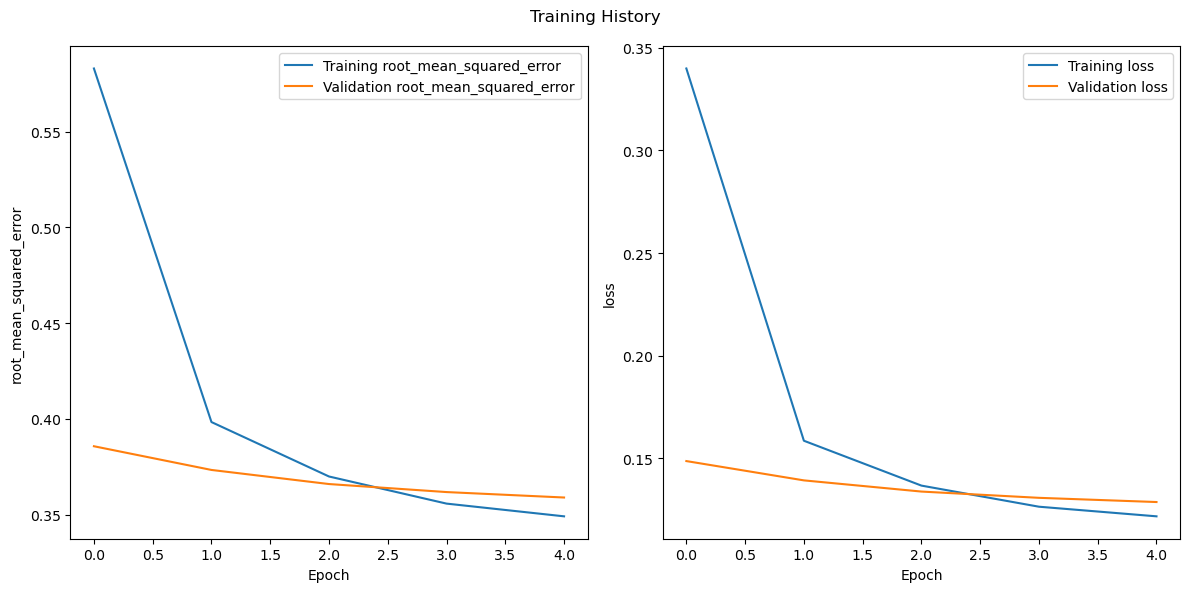

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
pd.options.mode.chained_assignment = None


# plot training history
Utils.plot_training_history(axes[0], history, "root_mean_squared_error")
Utils.plot_training_history(axes[1], history, "loss")

# Mostrar el gráfico
fig.suptitle("Training History")
fig.tight_layout()
plt.show()


In [ ]:
"""
Evaluate the model over the validation data, if the metrics are not good, change the model an test again
"""
metric = model_one_shot_cluster.evaluate(val_sequence_feature_cross, val_labels_feature_cross)

print("The values of Loss and Root Mean Squared Error are: ", metric)

5390/5390 [==============================] - 20s 3ms/step - loss: 0.1288 - root_mean_squared_error: 0.3589
The values of Loss and Root Mean Squared Error are:  [0.12879373133182526, 0.3588784337043762]


In [ ]:
ppna_df.head()
#test_df_feature_cross.head()

,id,date,longitude,latitude,ppna,ppt,temp,timestamp_date,date_signal
0,0,2001-01-01,-56.83242,-31.544792,405.340618,76.155505,24.333897,978307200.0,0.008300
1,1,2001-01-17,-56.83242,-31.544792,362.433361,91.647396,23.921929,979689600.0,0.279761
2,2,2001-02-02,-56.83242,-31.544792,420.441046,80.999538,24.132180,981072000.0,0.530160
3,3,2001-02-18,-56.83242,-31.544792,335.261458,88.673292,26.170466,982454400.0,0.740648
4,4,2001-03-06,-56.83242,-31.544792,301.399079,5.496469,24.043910,983836800.0,0.895377


train sequence: (num train data, past_data, features) -> (22, 24, 12)
label sequence: (num train data, label) ->  (22, 1)
1/1 [==============================] - 4s 4s/step


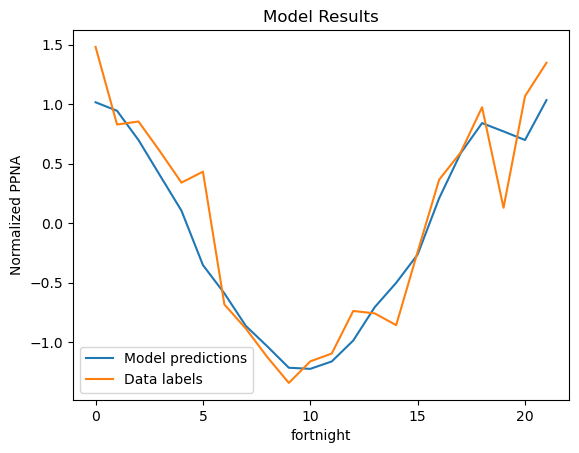

In [ ]:
"""
Test the model and view the results: In this case, the model is tested over a fixed location 
"""

test_sequence_fixed_position_df = DataManager(test_df_feature_cross[(test_df['longitude'] == ppna_df['longitude'][40000]) & (test_df['latitude'] == ppna_df['latitude'][40000])])
test_sequence_fixed_position , test_labels_fixed_position = test_sequence_fixed_position_df.sequence_data_preparation(INPUT_STEPS, OUTPUT_STEPS)
print("train sequence: (num train data, past_data, features) ->", test_sequence_fixed_position.shape )
print("label sequence: (num train data, label) -> ", test_labels_fixed_position.shape)

predict = model_one_shot_cluster.predict(test_sequence_fixed_position)

plt.title("Model Results")
plt.plot(predict, label="Model predictions")
plt.plot(test_labels_fixed_position, label="Data labels")


plt.xlabel("fortnight")
plt.ylabel("Normalized PPNA")
plt.legend()
plt.show()

### New data clustering

This section shows code developed to assign a cluster id to the new incoming data needed for predictions. The  hypothetical scenario is as follows: client asks for a prediction at a particular location; they enter said location and the program categorises it into a cluster to further feed the model.

In [ ]:
centers

array([[-32.96561138, -56.16084226],
       [-30.74992528, -57.4256069 ],
       [-31.38522276, -57.33303046],
       [-32.94988952, -56.81693907],
       [-30.4463202 , -56.89231138],
       [-31.01473872, -56.56030095],
       [-32.28556286, -56.19177935],
       [-32.22637987, -56.81737086]])

In [ ]:
#FOR TESTING ONLY

new_data_point = {'latitude': -32.96561138, 'longitude': -57.16084226}
new_data_df = pd.DataFrame([new_data_point])
new_data_df


,latitude,longitude
0,-32.965611,-57.160842


In [ ]:
'''
Function to assign a cluster to a new data point. The function receives a pandas dataframe and adds a new column with the
corresponding cluster id to said df. If there are no coordinates to evaluate, throws an exception
'''

def new_data_clustering(new_data):
    # Asegúrate de que new_data tiene las columnas 'latitude' y 'longitude'
    if 'latitude' not in new_data.columns or 'longitude' not in new_data.columns:
        raise ValueError("El DataFrame debe contener las columnas 'latitude' y 'longitude'.")

    new_data['cluster'] = kmeans.predict(new_data[['latitude', 'longitude']])


new_data_clustering(new_data_df)
new_data_df


,latitude,longitude,cluster
0,-32.965611,-57.160842,3
